In [1]:
import gc
import logging
logging.disable(logging.WARNING)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import mixed_precision
from tensorflow.keras.utils import plot_model
import tensorflow_probability as tfp

mixed_precision.set_global_policy('mixed_float16')
print(tf.__version__)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3080 Ti, compute capability 8.6
2.6.2


In [2]:
# Load data
df = pd.read_parquet('E:/train_low_mem.parquet')
df.drop(['time_id', 'row_id'], inplace=True, axis=1)
investment_id = df.pop("investment_id")
y = df.pop("target")

investment_ids = list(investment_id.unique())
investment_id_lookup_layer = IntegerLookup(oov_token=-1, output_mode='int')
investment_id_lookup_layer.adapt(np.array(investment_ids))
vocab = investment_id_lookup_layer.get_vocabulary(include_special_tokens=True)
vocab_size = investment_id_lookup_layer.vocabulary_size()
print(max(investment_ids))
print(vocab_size)

3773
3580


In [3]:
def preprocess(x, y):
    # TODO
    return x, y

def make_dataset(feature, investment_id, y, batch_size=2048, mode='train'):
    ds = tf.data.Dataset.from_tensor_slices(((investment_id, feature), y))
    ds = ds.map(preprocess)
    if mode == "train": ds = ds.shuffle(8192, seed=69)  # only shuffle when training
    ds = ds.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
    return ds


# Pearson correlation coefficient loss and metrics
def pearson_corr(y_true, y_pred, axis=-1):
    return tfp.stats.correlation(tf.squeeze(y_pred), tf.squeeze(y_true), sample_axis=axis, event_axis=None)

def pearson_corr_loss(y_true, y_pred, axis=-1):
    return 1 - tf.math.abs(pearson_corr(y_true, y_pred, axis=axis))

In [4]:
# Model
def build_model():
    investment_id_inputs = Input((1, ), name='inv_id_in', dtype=tf.uint16)
    features_inputs = Input((300, ), name='feature_in', dtype=tf.float16)

    investment_id_x = investment_id_lookup_layer(investment_id_inputs)
    investment_id_x = Embedding(vocab_size, 64, input_length=1)(investment_id_x)
    investment_id_x = Reshape((-1, ))(investment_id_x)
    investment_id_x = Dense(64, activation='swish')(investment_id_x)
    # investment_id_x = Dropout(0.2)(investment_id_x)
    investment_id_x = Dense(64, activation='swish')(investment_id_x)
    # investment_id_x = Dropout(0.2)(investment_id_x)
    investment_id_x = Dense(64, activation='swish')(investment_id_x)
    # investment_id_x = Dropout(0.2)(investment_id_x)

    feature_x = GaussianNoise(0.01)(features_inputs)
    feature_x = Dense(256, activation='swish')(feature_x)
    # feature_x = Dropout(0.2)(feature_x)
    feature_x = Dense(256, activation='swish')(feature_x)
    # feature_x = Dropout(0.2)(feature_x)
    feature_x = Dense(256, activation='swish')(feature_x)
    # feature_x = Dropout(0.2)(feature_x)

    x = Concatenate(axis=1)([investment_id_x, feature_x])
    x = Dense(512, activation='swish', kernel_regularizer="l2")(x)
    # x = Dropout(0.2)(x)
    x = Dense(128, activation='swish', kernel_regularizer="l2")(x)
    # x = Dropout(0.2)(x)
    x = Dense(32, activation='swish', kernel_regularizer="l2")(x)
    # x = Dropout(0.2)(x)
    xOut = Dense(1, name='output')(x)

    model = Model(inputs=[investment_id_inputs, features_inputs], outputs=[xOut])
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['mse'])
    return model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inv_id_in (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
integer_lookup (IntegerLookup)  (None, 1)            0           inv_id_in[0][0]                  
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 64)        229120      integer_lookup[0][0]             
__________________________________________________________________________________________________
feature_in (InputLayer)         [(None, 300)]        0                                            
______________________________________________________________________________________________

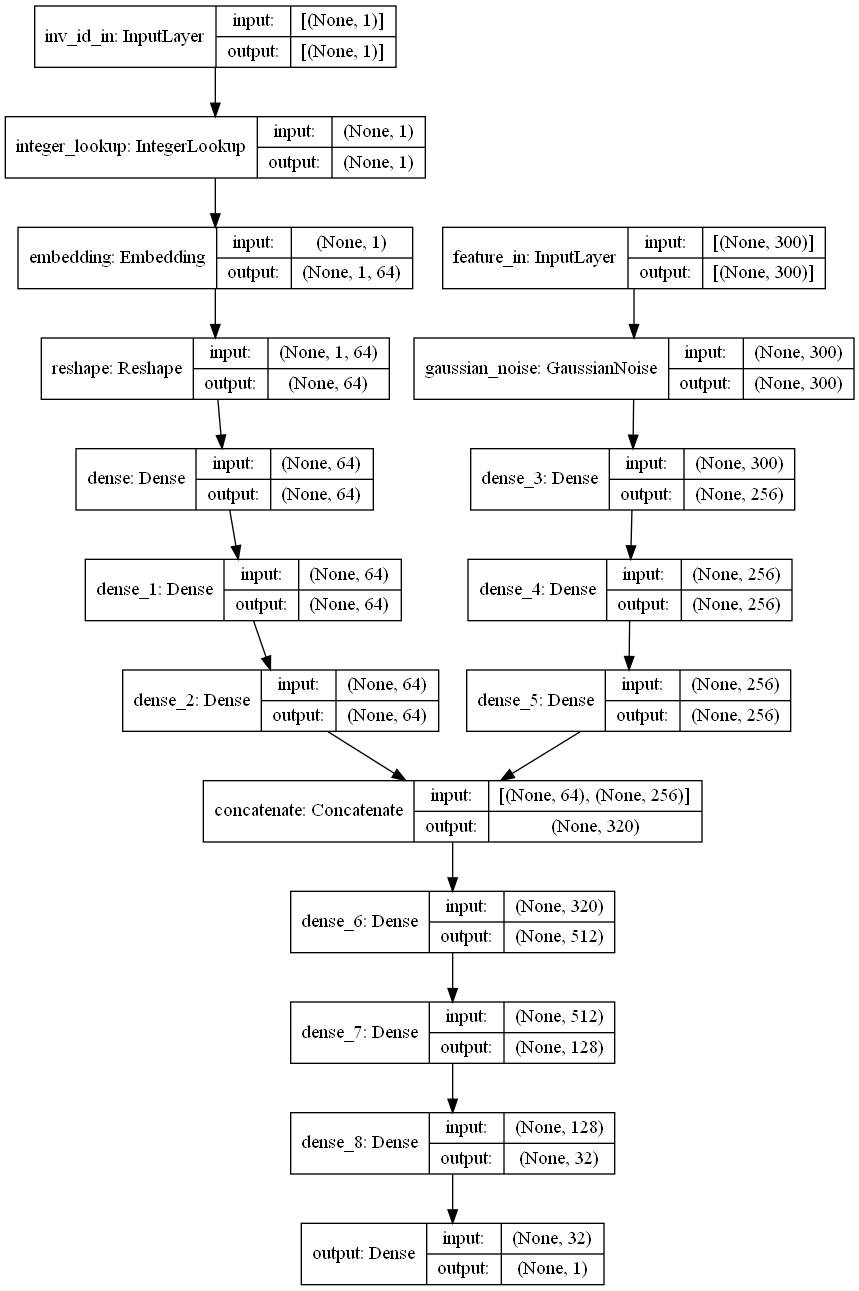

In [5]:
model = build_model()
model.summary()
plot_model(model, to_file='model.png', show_shapes=True)

In [6]:
import scipy
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=69)
models = []

for index, (train_indices, valid_indices) in enumerate(kfold.split(df, investment_id)):
    X_train, X_val = df.iloc[train_indices], df.iloc[valid_indices]
    investment_id_train = investment_id[train_indices]
    y_train, y_val = y.iloc[train_indices], y.iloc[valid_indices]
    investment_id_val = investment_id[valid_indices]
    train_ds = make_dataset(X_train, investment_id_train, y_train)
    valid_ds = make_dataset(X_val, investment_id_val, y_val, mode="valid")
    model = build_model()
    callbacks = [tf.keras.callbacks.ModelCheckpoint(f"model_{index}", monitor='val_mse', save_best_only=True),
                 tf.keras.callbacks.EarlyStopping(patience=13, monitor='val_mse', verbose=1, restore_best_weights=True),
                 tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=6, verbose=1)]
    history = model.fit(train_ds, epochs=50, validation_data=valid_ds, callbacks=callbacks)
    models.append(load_model(f"model_{index}", custom_objects={'pearson_corr': pearson_corr, 'pearson_corr_loss': pearson_corr_loss}))

    pearson_score = scipy.stats.pearsonr(model.predict(valid_ds).ravel(), y_val.values)[0]
    print('Pearson:', pearson_score)
    # pd.DataFrame(history.history, columns=["mse", "val_mse"]).plot()
    # plt.title("MSE")
    # plt.show()
    # pd.DataFrame(history.history, columns=["mae", "val_mae"]).plot()
    # plt.title("MAE")
    # plt.show()
    del investment_id_train
    del investment_id_val
    del X_train
    del X_val
    del y_train
    del y_val
    del train_ds
    del valid_ds
    del model
    gc.collect()

C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=6.
  warnings.warn(


Epoch 1/50
1279/1279 [==============================] - 15s 8ms/step - loss: 0.9798 - mse: 0.8326 - val_loss: 0.8314 - val_mse: 0.8297
INFO:tensorflow:Assets written to: model_0\assets
Epoch 2/50
1279/1279 [==============================] - 9s 7ms/step - loss: 0.8315 - mse: 0.8288 - val_loss: 0.8309 - val_mse: 0.8291
INFO:tensorflow:Assets written to: model_0\assets
Epoch 3/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8297 - mse: 0.8264 - val_loss: 0.8300 - val_mse: 0.8280
INFO:tensorflow:Assets written to: model_0\assets
Epoch 4/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8280 - mse: 0.8243 - val_loss: 0.8295 - val_mse: 0.8278
INFO:tensorflow:Assets written to: model_0\assets
Epoch 5/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8264 - mse: 0.8222 - val_loss: 0.8290 - val_mse: 0.8272
INFO:tensorflow:Assets written to: model_0\assets
Epoch 6/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8

Restoring model weights from the end of the best epoch.
Epoch 00019: early stopping


Pearson: 0.12933734434131697
Epoch 1/50
1279/1279 [==============================] - 12s 8ms/step - loss: 0.9774 - mse: 0.8318 - val_loss: 0.8408 - val_mse: 0.8385
INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


Epoch 2/50
1279/1279 [==============================] - 8s 6ms/step - loss: 0.8310 - mse: 0.8280 - val_loss: 0.8391 - val_mse: 0.8345
INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


Epoch 3/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8289 - mse: 0.8256 - val_loss: 0.8369 - val_mse: 0.8340
INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


Epoch 4/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8270 - mse: 0.8236 - val_loss: 0.8373 - val_mse: 0.8343
Epoch 5/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8259 - mse: 0.8212 - val_loss: 0.8370 - val_mse: 0.8343
Epoch 6/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8237 - mse: 0.8182 - val_loss: 0.8356 - val_mse: 0.8335
INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


Epoch 7/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8217 - mse: 0.8160 - val_loss: 0.8366 - val_mse: 0.8337
Epoch 8/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8201 - mse: 0.8137 - val_loss: 0.8355 - val_mse: 0.8330
INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


Epoch 9/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8179 - mse: 0.8114 - val_loss: 0.8358 - val_mse: 0.8336
Epoch 10/50
1279/1279 [==============================] - 6s 4ms/step - loss: 0.8156 - mse: 0.8083 - val_loss: 0.8372 - val_mse: 0.8344
Epoch 11/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8118 - mse: 0.8041 - val_loss: 0.8384 - val_mse: 0.8351
Epoch 12/50
1279/1279 [==============================] - 6s 4ms/step - loss: 0.8074 - mse: 0.7998 - val_loss: 0.8398 - val_mse: 0.8363
Epoch 13/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8043 - mse: 0.7958 - val_loss: 0.8417 - val_mse: 0.8379
Epoch 14/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8008 - mse: 0.7918 - val_loss: 0.8425 - val_mse: 0.8391

Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 15/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8077 - mse: 0.8032 - val_loss:

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping


Pearson: 0.13010714908716856
Epoch 1/50
1279/1279 [==============================] - 11s 8ms/step - loss: 0.9784 - mse: 0.8319 - val_loss: 0.8373 - val_mse: 0.8353
INFO:tensorflow:Assets written to: model_2\assets


INFO:tensorflow:Assets written to: model_2\assets


Epoch 2/50
1279/1279 [==============================] - 9s 7ms/step - loss: 0.8306 - mse: 0.8280 - val_loss: 0.8373 - val_mse: 0.8351
INFO:tensorflow:Assets written to: model_2\assets


INFO:tensorflow:Assets written to: model_2\assets


Epoch 3/50
1279/1279 [==============================] - 7s 5ms/step - loss: 0.8285 - mse: 0.8257 - val_loss: 0.8375 - val_mse: 0.8353
Epoch 4/50
1279/1279 [==============================] - 7s 5ms/step - loss: 0.8266 - mse: 0.8236 - val_loss: 0.8325 - val_mse: 0.8305
INFO:tensorflow:Assets written to: model_2\assets


INFO:tensorflow:Assets written to: model_2\assets


Epoch 5/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8271 - mse: 0.8217 - val_loss: 0.8331 - val_mse: 0.8312
Epoch 6/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8233 - mse: 0.8189 - val_loss: 0.8351 - val_mse: 0.8325
Epoch 7/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8215 - mse: 0.8161 - val_loss: 0.8390 - val_mse: 0.8356
Epoch 8/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8187 - mse: 0.8128 - val_loss: 0.8416 - val_mse: 0.8389
Epoch 9/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8155 - mse: 0.8094 - val_loss: 0.8418 - val_mse: 0.8387
Epoch 10/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8132 - mse: 0.8065 - val_loss: 0.8403 - val_mse: 0.8368

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 11/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8141 - mse: 0.8103 - val_loss: 0.8

Restoring model weights from the end of the best epoch.
Epoch 00017: early stopping


Pearson: 0.1326649240504337
Epoch 1/50
1279/1279 [==============================] - 11s 7ms/step - loss: 0.9794 - mse: 0.8330 - val_loss: 0.8327 - val_mse: 0.8309
INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets


Epoch 2/50
1279/1279 [==============================] - 8s 6ms/step - loss: 0.8318 - mse: 0.8292 - val_loss: 0.8309 - val_mse: 0.8289
INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets


Epoch 3/50
1279/1279 [==============================] - 7s 5ms/step - loss: 0.8298 - mse: 0.8268 - val_loss: 0.8301 - val_mse: 0.8283
INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets


Epoch 4/50
1279/1279 [==============================] - 7s 5ms/step - loss: 0.8282 - mse: 0.8248 - val_loss: 0.8293 - val_mse: 0.8278
INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets


Epoch 5/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8282 - mse: 0.8230 - val_loss: 0.8289 - val_mse: 0.8268
INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets


Epoch 6/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8254 - mse: 0.8202 - val_loss: 0.8294 - val_mse: 0.8267
INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets


Epoch 7/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8228 - mse: 0.8170 - val_loss: 0.8307 - val_mse: 0.8268
Epoch 8/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8209 - mse: 0.8141 - val_loss: 0.8318 - val_mse: 0.8278
Epoch 9/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8177 - mse: 0.8112 - val_loss: 0.8347 - val_mse: 0.8289
Epoch 10/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8146 - mse: 0.8074 - val_loss: 0.8354 - val_mse: 0.8291
Epoch 11/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8116 - mse: 0.8038 - val_loss: 0.8403 - val_mse: 0.8324

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 12/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8141 - mse: 0.8097 - val_loss: 0.8334 - val_mse: 0.8291
Epoch 13/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8105 - mse: 0.8063 - val_loss: 0

INFO:tensorflow:Assets written to: model_3\assets


Epoch 19/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8061 - mse: 0.8030 - val_loss: 0.8274 - val_mse: 0.8245
INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets


Epoch 20/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8057 - mse: 0.8026 - val_loss: 0.8272 - val_mse: 0.8243
INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets


Epoch 21/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8054 - mse: 0.8023 - val_loss: 0.8271 - val_mse: 0.8241
INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets


Epoch 22/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8051 - mse: 0.8021 - val_loss: 0.8270 - val_mse: 0.8240
INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets


Epoch 23/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8049 - mse: 0.8019 - val_loss: 0.8269 - val_mse: 0.8240
INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets


Epoch 24/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8046 - mse: 0.8016 - val_loss: 0.8269 - val_mse: 0.8240
INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets


Epoch 25/50
1279/1279 [==============================] - 7s 5ms/step - loss: 0.8044 - mse: 0.8014 - val_loss: 0.8269 - val_mse: 0.8239
INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets


Epoch 26/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8042 - mse: 0.8013 - val_loss: 0.8268 - val_mse: 0.8239
INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets


Epoch 27/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8040 - mse: 0.8011 - val_loss: 0.8268 - val_mse: 0.8239
INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets


Epoch 28/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8039 - mse: 0.8009 - val_loss: 0.8268 - val_mse: 0.8239
INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets


Epoch 29/50
1279/1279 [==============================] - 7s 5ms/step - loss: 0.8037 - mse: 0.8007 - val_loss: 0.8268 - val_mse: 0.8239
Epoch 30/50
1279/1279 [==============================] - 7s 5ms/step - loss: 0.8035 - mse: 0.8005 - val_loss: 0.8268 - val_mse: 0.8239
Epoch 31/50
1279/1279 [==============================] - 7s 5ms/step - loss: 0.8033 - mse: 0.8004 - val_loss: 0.8268 - val_mse: 0.8239
Epoch 32/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8032 - mse: 0.8002 - val_loss: 0.8268 - val_mse: 0.8239
Epoch 33/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8030 - mse: 0.8000 - val_loss: 0.8268 - val_mse: 0.8239

Epoch 00033: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 34/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8059 - mse: 0.8032 - val_loss: 0.8248 - val_mse: 0.8221
INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets


Epoch 35/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8045 - mse: 0.8018 - val_loss: 0.8243 - val_mse: 0.8216
INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets


Epoch 36/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8040 - mse: 0.8014 - val_loss: 0.8240 - val_mse: 0.8214
INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets


Epoch 37/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8038 - mse: 0.8012 - val_loss: 0.8238 - val_mse: 0.8213
INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets


Epoch 38/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8037 - mse: 0.8011 - val_loss: 0.8237 - val_mse: 0.8211
INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets


Epoch 39/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8037 - mse: 0.8011 - val_loss: 0.8236 - val_mse: 0.8211
INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets


Epoch 40/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8036 - mse: 0.8011 - val_loss: 0.8236 - val_mse: 0.8211
INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets


Epoch 41/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8036 - mse: 0.8010 - val_loss: 0.8236 - val_mse: 0.8210
INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets


Epoch 42/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8036 - mse: 0.8010 - val_loss: 0.8236 - val_mse: 0.8210
INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets


Epoch 43/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8036 - mse: 0.8010 - val_loss: 0.8236 - val_mse: 0.8210
INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets


Epoch 44/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8035 - mse: 0.8009 - val_loss: 0.8236 - val_mse: 0.8210
INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets


Epoch 45/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8035 - mse: 0.8009 - val_loss: 0.8236 - val_mse: 0.8210
Epoch 46/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8035 - mse: 0.8009 - val_loss: 0.8236 - val_mse: 0.8210
INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets



Epoch 00046: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 47/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8035 - mse: 0.8009 - val_loss: 0.8236 - val_mse: 0.8211
Epoch 48/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8035 - mse: 0.8009 - val_loss: 0.8237 - val_mse: 0.8211
Epoch 49/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8034 - mse: 0.8009 - val_loss: 0.8237 - val_mse: 0.8212
Epoch 50/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8034 - mse: 0.8009 - val_loss: 0.8238 - val_mse: 0.8212


Pearson: 0.16124526612563697
Epoch 1/50
1279/1279 [==============================] - 11s 7ms/step - loss: 0.9773 - mse: 0.8308 - val_loss: 0.8471 - val_mse: 0.8450
INFO:tensorflow:Assets written to: model_4\assets


INFO:tensorflow:Assets written to: model_4\assets


Epoch 2/50
1279/1279 [==============================] - 7s 6ms/step - loss: 0.8288 - mse: 0.8265 - val_loss: 0.8462 - val_mse: 0.8432
INFO:tensorflow:Assets written to: model_4\assets


INFO:tensorflow:Assets written to: model_4\assets


Epoch 3/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8269 - mse: 0.8242 - val_loss: 0.8431 - val_mse: 0.8414
INFO:tensorflow:Assets written to: model_4\assets


INFO:tensorflow:Assets written to: model_4\assets


Epoch 4/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8263 - mse: 0.8223 - val_loss: 0.8428 - val_mse: 0.8410
INFO:tensorflow:Assets written to: model_4\assets


INFO:tensorflow:Assets written to: model_4\assets


Epoch 5/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8239 - mse: 0.8200 - val_loss: 0.8439 - val_mse: 0.8420
Epoch 6/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8224 - mse: 0.8171 - val_loss: 0.8402 - val_mse: 0.8387
INFO:tensorflow:Assets written to: model_4\assets


INFO:tensorflow:Assets written to: model_4\assets


Epoch 7/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8216 - mse: 0.8154 - val_loss: 0.8402 - val_mse: 0.8388
Epoch 8/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8182 - mse: 0.8123 - val_loss: 0.8401 - val_mse: 0.8385
INFO:tensorflow:Assets written to: model_4\assets


INFO:tensorflow:Assets written to: model_4\assets


Epoch 9/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8152 - mse: 0.8091 - val_loss: 0.8403 - val_mse: 0.8384
INFO:tensorflow:Assets written to: model_4\assets


INFO:tensorflow:Assets written to: model_4\assets


Epoch 10/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8114 - mse: 0.8046 - val_loss: 0.8407 - val_mse: 0.8385
Epoch 11/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8073 - mse: 0.8003 - val_loss: 0.8419 - val_mse: 0.8393
Epoch 12/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8059 - mse: 0.7973 - val_loss: 0.8415 - val_mse: 0.8390

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 13/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8091 - mse: 0.8048 - val_loss: 0.8485 - val_mse: 0.8439
Epoch 14/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8048 - mse: 0.8000 - val_loss: 0.8494 - val_mse: 0.8448
Epoch 15/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8025 - mse: 0.7978 - val_loss: 0.8496 - val_mse: 0.8450
Epoch 16/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8007 - mse: 0.7959 - val_loss

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping


Pearson: 0.13149126360142527
Epoch 1/50
1279/1279 [==============================] - 11s 7ms/step - loss: 0.9768 - mse: 0.8312 - val_loss: 0.8430 - val_mse: 0.8412
INFO:tensorflow:Assets written to: model_5\assets


INFO:tensorflow:Assets written to: model_5\assets


Epoch 2/50
1279/1279 [==============================] - 7s 6ms/step - loss: 0.8295 - mse: 0.8268 - val_loss: 0.8427 - val_mse: 0.8407
INFO:tensorflow:Assets written to: model_5\assets


INFO:tensorflow:Assets written to: model_5\assets


Epoch 3/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8271 - mse: 0.8245 - val_loss: 0.8438 - val_mse: 0.8409
Epoch 4/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8259 - mse: 0.8227 - val_loss: 0.8419 - val_mse: 0.8393
INFO:tensorflow:Assets written to: model_5\assets


INFO:tensorflow:Assets written to: model_5\assets


Epoch 5/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8243 - mse: 0.8204 - val_loss: 0.8431 - val_mse: 0.8398
Epoch 6/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8225 - mse: 0.8178 - val_loss: 0.8440 - val_mse: 0.8419
Epoch 7/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8200 - mse: 0.8151 - val_loss: 0.8418 - val_mse: 0.8396
Epoch 8/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8176 - mse: 0.8120 - val_loss: 0.8423 - val_mse: 0.8395
Epoch 9/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8148 - mse: 0.8088 - val_loss: 0.8449 - val_mse: 0.8420
Epoch 10/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8130 - mse: 0.8063 - val_loss: 0.8441 - val_mse: 0.8406

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 11/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8145 - mse: 0.8106 - val_loss: 0.8

INFO:tensorflow:Assets written to: model_5\assets


Epoch 12/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8109 - mse: 0.8068 - val_loss: 0.8424 - val_mse: 0.8389
Epoch 13/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8091 - mse: 0.8050 - val_loss: 0.8423 - val_mse: 0.8388
Epoch 14/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8076 - mse: 0.8035 - val_loss: 0.8425 - val_mse: 0.8390
Epoch 15/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8063 - mse: 0.8022 - val_loss: 0.8428 - val_mse: 0.8393
Epoch 16/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8051 - mse: 0.8010 - val_loss: 0.8432 - val_mse: 0.8396

Epoch 00016: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 17/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8088 - mse: 0.8056 - val_loss: 0.8378 - val_mse: 0.8350
INFO:tensorflow:Assets written to: model_5\assets


INFO:tensorflow:Assets written to: model_5\assets


Epoch 18/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8072 - mse: 0.8043 - val_loss: 0.8374 - val_mse: 0.8346
INFO:tensorflow:Assets written to: model_5\assets


INFO:tensorflow:Assets written to: model_5\assets


Epoch 19/50
1279/1279 [==============================] - 7s 5ms/step - loss: 0.8068 - mse: 0.8040 - val_loss: 0.8371 - val_mse: 0.8343
INFO:tensorflow:Assets written to: model_5\assets


INFO:tensorflow:Assets written to: model_5\assets


Epoch 20/50
1279/1279 [==============================] - 7s 5ms/step - loss: 0.8065 - mse: 0.8037 - val_loss: 0.8371 - val_mse: 0.8342
INFO:tensorflow:Assets written to: model_5\assets


INFO:tensorflow:Assets written to: model_5\assets


Epoch 21/50
1279/1279 [==============================] - 7s 5ms/step - loss: 0.8063 - mse: 0.8035 - val_loss: 0.8370 - val_mse: 0.8341
INFO:tensorflow:Assets written to: model_5\assets


INFO:tensorflow:Assets written to: model_5\assets


Epoch 22/50
1279/1279 [==============================] - 7s 5ms/step - loss: 0.8061 - mse: 0.8033 - val_loss: 0.8369 - val_mse: 0.8340
INFO:tensorflow:Assets written to: model_5\assets


INFO:tensorflow:Assets written to: model_5\assets


Epoch 23/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8058 - mse: 0.8031 - val_loss: 0.8369 - val_mse: 0.8340
INFO:tensorflow:Assets written to: model_5\assets


INFO:tensorflow:Assets written to: model_5\assets


Epoch 24/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8056 - mse: 0.8029 - val_loss: 0.8368 - val_mse: 0.8339
INFO:tensorflow:Assets written to: model_5\assets


INFO:tensorflow:Assets written to: model_5\assets


Epoch 25/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8055 - mse: 0.8027 - val_loss: 0.8368 - val_mse: 0.8339
INFO:tensorflow:Assets written to: model_5\assets


INFO:tensorflow:Assets written to: model_5\assets


Epoch 26/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8053 - mse: 0.8025 - val_loss: 0.8367 - val_mse: 0.8339
INFO:tensorflow:Assets written to: model_5\assets


INFO:tensorflow:Assets written to: model_5\assets


Epoch 27/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8051 - mse: 0.8024 - val_loss: 0.8367 - val_mse: 0.8338
INFO:tensorflow:Assets written to: model_5\assets


INFO:tensorflow:Assets written to: model_5\assets


Epoch 28/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8049 - mse: 0.8022 - val_loss: 0.8367 - val_mse: 0.8338
INFO:tensorflow:Assets written to: model_5\assets


INFO:tensorflow:Assets written to: model_5\assets


Epoch 29/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8047 - mse: 0.8020 - val_loss: 0.8366 - val_mse: 0.8338
INFO:tensorflow:Assets written to: model_5\assets


INFO:tensorflow:Assets written to: model_5\assets


Epoch 30/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8046 - mse: 0.8019 - val_loss: 0.8366 - val_mse: 0.8337
INFO:tensorflow:Assets written to: model_5\assets


INFO:tensorflow:Assets written to: model_5\assets


Epoch 31/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8044 - mse: 0.8017 - val_loss: 0.8366 - val_mse: 0.8337
INFO:tensorflow:Assets written to: model_5\assets


INFO:tensorflow:Assets written to: model_5\assets


Epoch 32/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8043 - mse: 0.8015 - val_loss: 0.8365 - val_mse: 0.8337
INFO:tensorflow:Assets written to: model_5\assets


INFO:tensorflow:Assets written to: model_5\assets


Epoch 33/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8041 - mse: 0.8014 - val_loss: 0.8365 - val_mse: 0.8337
INFO:tensorflow:Assets written to: model_5\assets


INFO:tensorflow:Assets written to: model_5\assets


Epoch 34/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8039 - mse: 0.8012 - val_loss: 0.8365 - val_mse: 0.8337
INFO:tensorflow:Assets written to: model_5\assets


INFO:tensorflow:Assets written to: model_5\assets


Epoch 35/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8038 - mse: 0.8011 - val_loss: 0.8365 - val_mse: 0.8337
Epoch 36/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8036 - mse: 0.8009 - val_loss: 0.8365 - val_mse: 0.8337
Epoch 37/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8035 - mse: 0.8008 - val_loss: 0.8365 - val_mse: 0.8337
INFO:tensorflow:Assets written to: model_5\assets


INFO:tensorflow:Assets written to: model_5\assets


Epoch 38/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8033 - mse: 0.8006 - val_loss: 0.8365 - val_mse: 0.8337

Epoch 00038: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 39/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8074 - mse: 0.8049 - val_loss: 0.8330 - val_mse: 0.8307
INFO:tensorflow:Assets written to: model_5\assets


INFO:tensorflow:Assets written to: model_5\assets


Epoch 40/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8055 - mse: 0.8032 - val_loss: 0.8324 - val_mse: 0.8301
INFO:tensorflow:Assets written to: model_5\assets


INFO:tensorflow:Assets written to: model_5\assets


Epoch 41/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8049 - mse: 0.8027 - val_loss: 0.8321 - val_mse: 0.8298
INFO:tensorflow:Assets written to: model_5\assets


INFO:tensorflow:Assets written to: model_5\assets


Epoch 42/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8048 - mse: 0.8025 - val_loss: 0.8320 - val_mse: 0.8297
INFO:tensorflow:Assets written to: model_5\assets


INFO:tensorflow:Assets written to: model_5\assets


Epoch 43/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8047 - mse: 0.8024 - val_loss: 0.8319 - val_mse: 0.8297
INFO:tensorflow:Assets written to: model_5\assets


INFO:tensorflow:Assets written to: model_5\assets


Epoch 44/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8046 - mse: 0.8023 - val_loss: 0.8319 - val_mse: 0.8297
INFO:tensorflow:Assets written to: model_5\assets


INFO:tensorflow:Assets written to: model_5\assets


Epoch 45/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8046 - mse: 0.8023 - val_loss: 0.8319 - val_mse: 0.8296
INFO:tensorflow:Assets written to: model_5\assets


INFO:tensorflow:Assets written to: model_5\assets


Epoch 46/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8045 - mse: 0.8022 - val_loss: 0.8319 - val_mse: 0.8296
INFO:tensorflow:Assets written to: model_5\assets


INFO:tensorflow:Assets written to: model_5\assets


Epoch 47/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8045 - mse: 0.8022 - val_loss: 0.8319 - val_mse: 0.8296
Epoch 48/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8045 - mse: 0.8022 - val_loss: 0.8319 - val_mse: 0.8296

Epoch 00048: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 49/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8045 - mse: 0.8022 - val_loss: 0.8320 - val_mse: 0.8297
Epoch 50/50
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8045 - mse: 0.8022 - val_loss: 0.8320 - val_mse: 0.8297


Pearson: 0.16470575732956266


In [8]:
from ubiquantEmulator import TimeSeriesAPI

def preprocess_test(investment_id, feature):
    return (investment_id, feature), 0

def make_test_dataset(feature, investment_id, batch_size=2048):
    ds = tf.data.Dataset.from_tensor_slices(((investment_id, feature)))
    ds = ds.map(preprocess_test)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
    return ds


def inference(models, ds):
    y_preds = []
    for model in models:
        y_pred = model.predict(ds)
        y_preds.append(y_pred)
    return np.mean(y_preds, axis=0)  # ensemble


models = [load_model(f"model_{index}", custom_objects={'pearson_corr': pearson_corr, 'pearson_corr_loss': pearson_corr_loss}) for index in range(kfold.n_splits)]
test = pd.read_csv('kaggle/input/ubiquant-market-prediction/train.csv', engine='pyarrow')
iter_test = TimeSeriesAPI(test[test["investment_id"] < 100][:100])
for n, (test_df, sample_prediction_df) in enumerate(iter_test):
    ds = make_test_dataset(test_df.loc[:, 'f_0':'f_299'], test_df["investment_id"])
    sample_prediction_df['target'] = inference(models, ds)
    iter_test.predict(sample_prediction_df)
print(sample_prediction_df)
print(f'Pearson: {scipy.stats.pearsonr(sample_prediction_df["target"].values, test_df["target"].values)[0]}')

   row_id    target
59    1_1  0.057434
60    1_2 -0.005116
61    1_6  0.013298
62    1_7 -0.002338
63    1_8  0.041046
64    1_9 -0.189941
65   1_10  0.051758
66   1_12  0.046783
67   1_13 -0.224365
68   1_14  0.017975
69   1_16  0.059387
70   1_17  0.004894
71   1_19  0.033966
72   1_20  0.031128
73   1_22 -0.104065
74   1_24 -0.127808
75   1_29 -0.038940
76   1_30  0.046509
77   1_31 -0.032257
78   1_32  0.015823
79   1_33  0.040009
80   1_34  0.008682
81   1_35  0.005745
82   1_36 -0.197754
83   1_40 -0.150391
84   1_41  0.025726
85   1_42 -0.117798
86   1_44  0.007706
87   1_46  0.030823
88   1_47  0.061493
89   1_48 -0.201416
90   1_50  0.086670
91   1_51 -0.059723
92   1_54  0.028442
93   1_55  0.019653
94   1_58 -0.092224
95   1_59 -0.012169
96   1_61  0.034454
97   1_62  0.004082
98   1_63  0.026550
99   1_66  0.006565
Pearson: 0.02489781465522549


In [9]:
import ubiquant
env = ubiquant.make_env()
iter_test = env.iter_test()
for (test_df, sample_prediction_df) in iter_test:
    ds = make_test_dataset(test_df.loc[:, 'f_0':'f_299'], test_df["investment_id"])
    sample_prediction_df['target'] = inference(models, ds)
    env.predict(sample_prediction_df)
print(sample_prediction_df)
print(f'Pearson: {scipy.stats.pearsonr(sample_prediction_df["target"].values, test_df["target"].values)[0]}')

ModuleNotFoundError: No module named 'ubiquant'